In [112]:
import pandas as pd
import numpy as np
import scipy.sparse
import scipy.stats
import sklearn.metrics
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering
import os, gc, re
import pylab as pl
import seaborn as sns

%matplotlib inline
pl.rcParams['figure.figsize'] = 10, 5
pd.__version__, sklearn.__version__, np.__version__

('0.17.1', '0.17', '1.10.4')

In [13]:
def memory_usage(df, ret=False, print_usage=True):
    if type(df) == pd.core.frame.DataFrame:
        m = df.memory_usage(index=True, deep=True).sum()/2**20
    elif type(df) == np.ndarray:
        m = df.nbytes/2**20
    else:
        m = df.data.nbytes/2**20
    if print_usage:
        print(m, 'Mb,', 'with shape =', df.shape)
    if ret:
        return m

In [3]:
def read_tosvmr(filename):
    if os.stat(filename).st_size == 0:
        return None
    df = pd.read_csv(filename, sep=' ', header=None)
    del df[7], df[6]
    df.columns = ['Rank', 'QueryID', 'CTR', 'CTP',
                  'Purchases', 'Turnover', 'ItemID']
    df.QueryID = df.QueryID.str.extract('qid:(\d+)').astype('int32')
    df.Rank = df.Rank.astype('int8')
    for i, col in enumerate(['CTR', 'CTP', 'Purchases', 'Turnover']):
        df[col] = df[col].str.extract(str(i+1) + ':(.+)').astype('float16')
    df.ItemID = df.ItemID.str.extract('item_id=(.+)')
    return df

In [ ]:
data = pd.DataFrame()
directory = '../data/svmr/'
size = 0
records = 0
# max_Rank, max_QID, max_ItemID_len = 0, 0, 0 # (2, 309111, 36)
# min_Rank, min_QID, min_ItemID_len = (2**63-1,)*3 # (1, 2, 36)
for i, filename in enumerate([f for f in os.listdir(directory) if re.match('.+\.tosvmr', f)]):
    chunk = read_tosvmr(os.path.join(directory, filename))
    if chunk is not None:
        qid = chunk.groupby('QueryID').Rank.agg('unique')
        qids = chunk.groupby('QueryID').Rank.nunique() > 1
        qids = set(qids[qids].index)
        chunk = chunk.ix[chunk.QueryID.isin(qids), ['Rank', 'QueryID', 'ItemID']]
        data = data.append(chunk)
        size += memory_usage(chunk, ret=True, print_usage=False)
        records += chunk.shape[0]
        if i % 20 == 0:
            print(i+1, 'file', filename)
            print('memory =', size, 'Mb', 'Records =', records)
    del chunk
print('TOTAL', 'memory =', size, 'Mb. Records =', records)

In [ ]:
data_filename = '../data/data.csv'
data.to_csv(data_filename, index=False)


In [ ]:
# data = read_tosvmr('../data/svmr/111AF73E-67E3-4E6E-BB32-3A7FB9B2F08A.tosvmr')
# qid = data.groupby('QueryID').Rank.agg('unique')
# qids = data.groupby('QueryID').Rank.nunique() > 1
# qids = set(qids[qids].index)
# data = data.ix[data.QueryID.isin(qids)]
# memory_usage(data)
# data.head()

In [8]:
data_filename = '../data/data.csv'
data = pd.read_csv(data_filename, dtype={'QueryID': 'int32', 'Rank': 'int8'})
memory_usage(data)
data.head()

2201.1405811309814 Mb, with shape = (21774181, 3)


,Rank,QueryID,ItemID
0,1,3220,B4180163-1E4B-4B7C-975E-7C99444C777B
1,1,3220,C19DF510-FD11-41AD-A794-2A1A58A4B9EF
2,1,3220,3FAFD53D-066E-49FA-B1DD-34ED9E592A17
3,1,3220,5978FEBB-DB0D-4EE9-B2E8-C5CAFEE23279
4,1,3220,A31CFDA1-CFA2-4AA8-836D-783DBE451694


In [14]:
queryID_encoder, itemID_encoder = LabelEncoder(), LabelEncoder()
S = scipy.sparse.coo_matrix((data.Rank.values, 
                             (queryID_encoder.fit_transform(data.QueryID.values),
                              itemID_encoder.fit_transform(data.ItemID.values)))).tocsr()
memory_usage(S)
S

20.512625694274902 Mb, with shape = (66660, 405632)


<66660x405632 sparse matrix of type '<class 'numpy.int8'>'
	with 21509047 stored elements in Compressed Sparse Row format>

In [15]:
del data
gc.collect()

509

In [16]:
def kendalltau_distance(x, y):
    mask_x = np.in1d(x.indices, y.indices)
    mask_y = np.in1d(y.indices, x.indices)
    vector_x = x.data[mask_x]
    vector_y = y.data[mask_y]
    intersection_size = mask_x.sum()
    if np.unique(vector_x).shape[0] == 1 or np.unique(vector_y).shape[0] == 1:
        vector_x = np.append(vector_x, [0])
        vector_y = np.append(vector_y, [0])
    if intersection_size == 0:
        tau = 0
    else:
        tau, pvalue = scipy.stats.kendalltau(vector_x, vector_y)
    return 2 - tau - intersection_size/np.max([x.data.shape[0], y.data.shape[0]])

In [124]:
n_queries = 1000
X = S[:n_queries, :]

In [125]:
%prun distance_matrix = sklearn.metrics.pairwise_distances(X, metric=kendalltau_distance)
print('is there a nan value? ', np.isnan(distance_matrix).any())
memory_usage(distance_matrix)

 is there a nan value?  False
7.62939453125 Mb, with shape = (1000, 1000)


In [126]:
distance_matrix_filename = '../data/distance_matrix' + str(n_queries) + '.csv'
np.savetxt(distance_matrix_filename, distance_matrix, delimiter=';')
print(distance_matrix_filename, 'created')

../data/distance_matrix1000.csv created


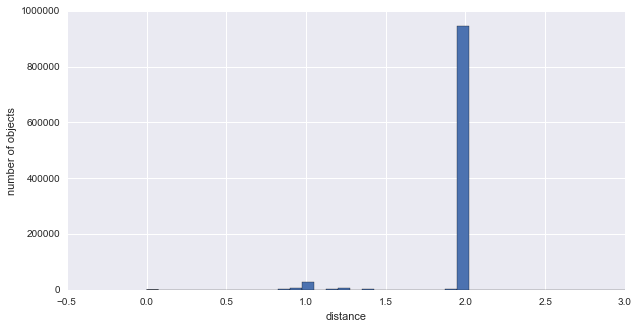

In [127]:
n, bins, patches = pl.hist(np.ravel(distance_matrix), bins=40)
pl.xlabel('distance')
pl.ylabel('number of objects')

# Plotting results


In [128]:
def plot_silhouettes(silhouette_values, labels):
    clusters = np.unique(labels)
    pl.figure()
    pl.title(str(clusters.shape[0]) + ' clusters. Avg silhouette =' + ('%.5f' % silhouette_values.mean()))
    y_lower = 20
    for i in clusters:
        cluster_silhouette_values = np.sort(silhouette_values[labels == i])
        y_upper = y_lower + cluster_silhouette_values.shape[0]

        cluster_silhouette_values = np.sort(silhouette_values[labels == i])
        pl.fill_betweenx(np.arange(y_lower,y_upper),
                           0, cluster_silhouette_values, facecolor=pl.cm.spectral(i/clusters.shape[0]), alpha=0.6)
        pl.text(-0.05, y_lower + 0.5 * cluster_silhouette_values.shape[0], str(i))
        y_lower = y_upper + 10
    pl.axvline(x=silhouette_values.mean(), color="red", linestyle="--")    

silhouette = -0.0919163641073


/home/oem/anaconda3/lib/python3.4/site-packages/sklearn/metrics/cluster/unsupervised.py:193: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1000 but corresponding boolean dimension is 109
  a = np.mean(distances_row[mask])
/home/oem/anaconda3/lib/python3.4/site-packages/sklearn/metrics/cluster/unsupervised.py:219: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1000 but corresponding boolean dimension is 109
  for cur_label in set(labels) if not cur_label == label])


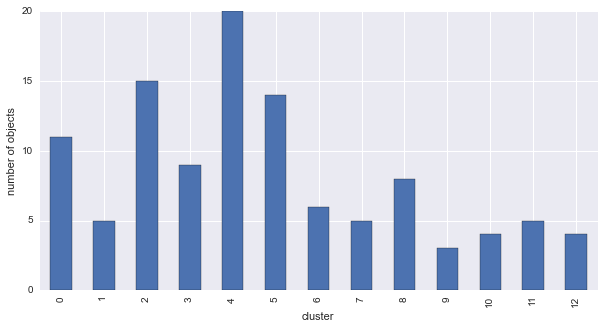

/home/oem/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


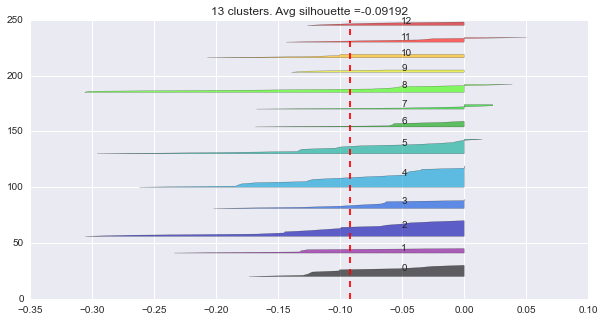

In [129]:
remove_noise = True
clustering = DBSCAN(metric='precomputed', eps=0.7, min_samples=4)
labels = clustering.fit_predict(distance_matrix)
if remove_noise:
    labels = labels[labels >= 0]
pd.Series(labels).value_counts().sort_index().plot(kind='bar')
pl.xlabel('cluster')
pl.ylabel('number of objects')
silhouette_values = sklearn.metrics.silhouette_samples(distance_matrix, labels, metric='precomputed')
print('silhouette =', silhouette_values.mean())
plot_silhouettes(silhouette_values, labels)

# KMeans with SVD and euclidian metric

In [130]:
u,s,v = scipy.sparse.linalg.svds(X.astype('f'), k=7)
u.shape, s.shape, v.shape

((1000, 7), (7,), (7, 405632))

2 0.945509764606
3 0.901604069349
4 0.71461136583
5 0.81203726761
6 0.736979816587
7 0.736491684275
8 0.730371849685
9 0.721299150881
10 0.682993084439
11 0.693897300232
12 0.69890070308
13 0.654661609822
14 0.683381827358
15 0.668302341527
16 0.655998441886
17 0.669008344662
18 0.678345283154
19 0.683928292684
20 0.654919118245
21 0.660211057175
22 0.674539309276
23 0.600353238174
24 0.526600439659


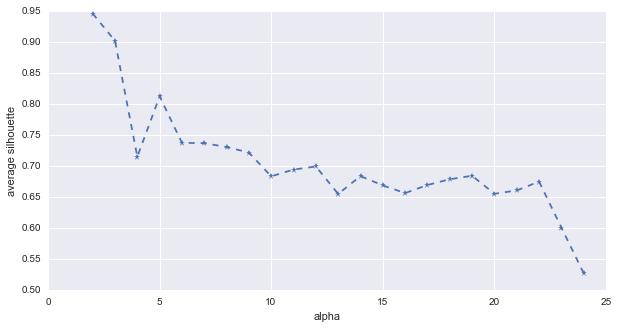

In [131]:
ks = np.arange(2,25)
silhouettes = np.zeros(ks.shape[0])
for i, k in enumerate(ks):
    clustering = KMeans(n_clusters=k)
    labels = clustering.fit_predict(u)
    if remove_noise:
        labels = labels[labels >= 0]
    silhouettes[i] = sklearn.metrics.silhouette_score(u, labels)
    print(k, silhouettes[i])
pl.plot(ks, silhouettes, '--*')
pl.xlabel('alpha')
pl.ylabel('average silhouette')
n_clusters = ks[np.argmax(silhouettes)]
# n_clusters = 13

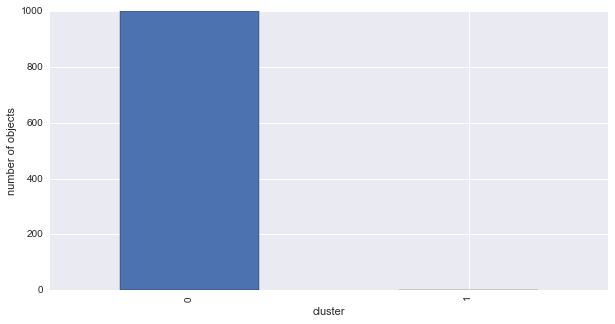

/home/oem/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


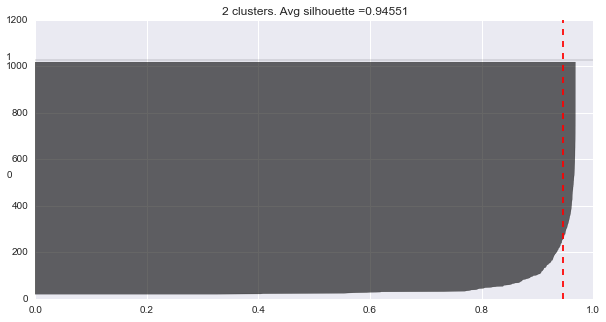

In [132]:
clustering = KMeans(n_clusters=n_clusters)
labels = clustering.fit_predict(u)
if remove_noise:
    labels = labels[labels >= 0]
pd.Series(labels).value_counts().sort_index().plot(kind='bar')
pl.xlabel('cluster')
pl.ylabel('number of objects')
silhouette_values = sklearn.metrics.silhouette_samples(u, labels)
plot_silhouettes(silhouette_values, labels)


/home/oem/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


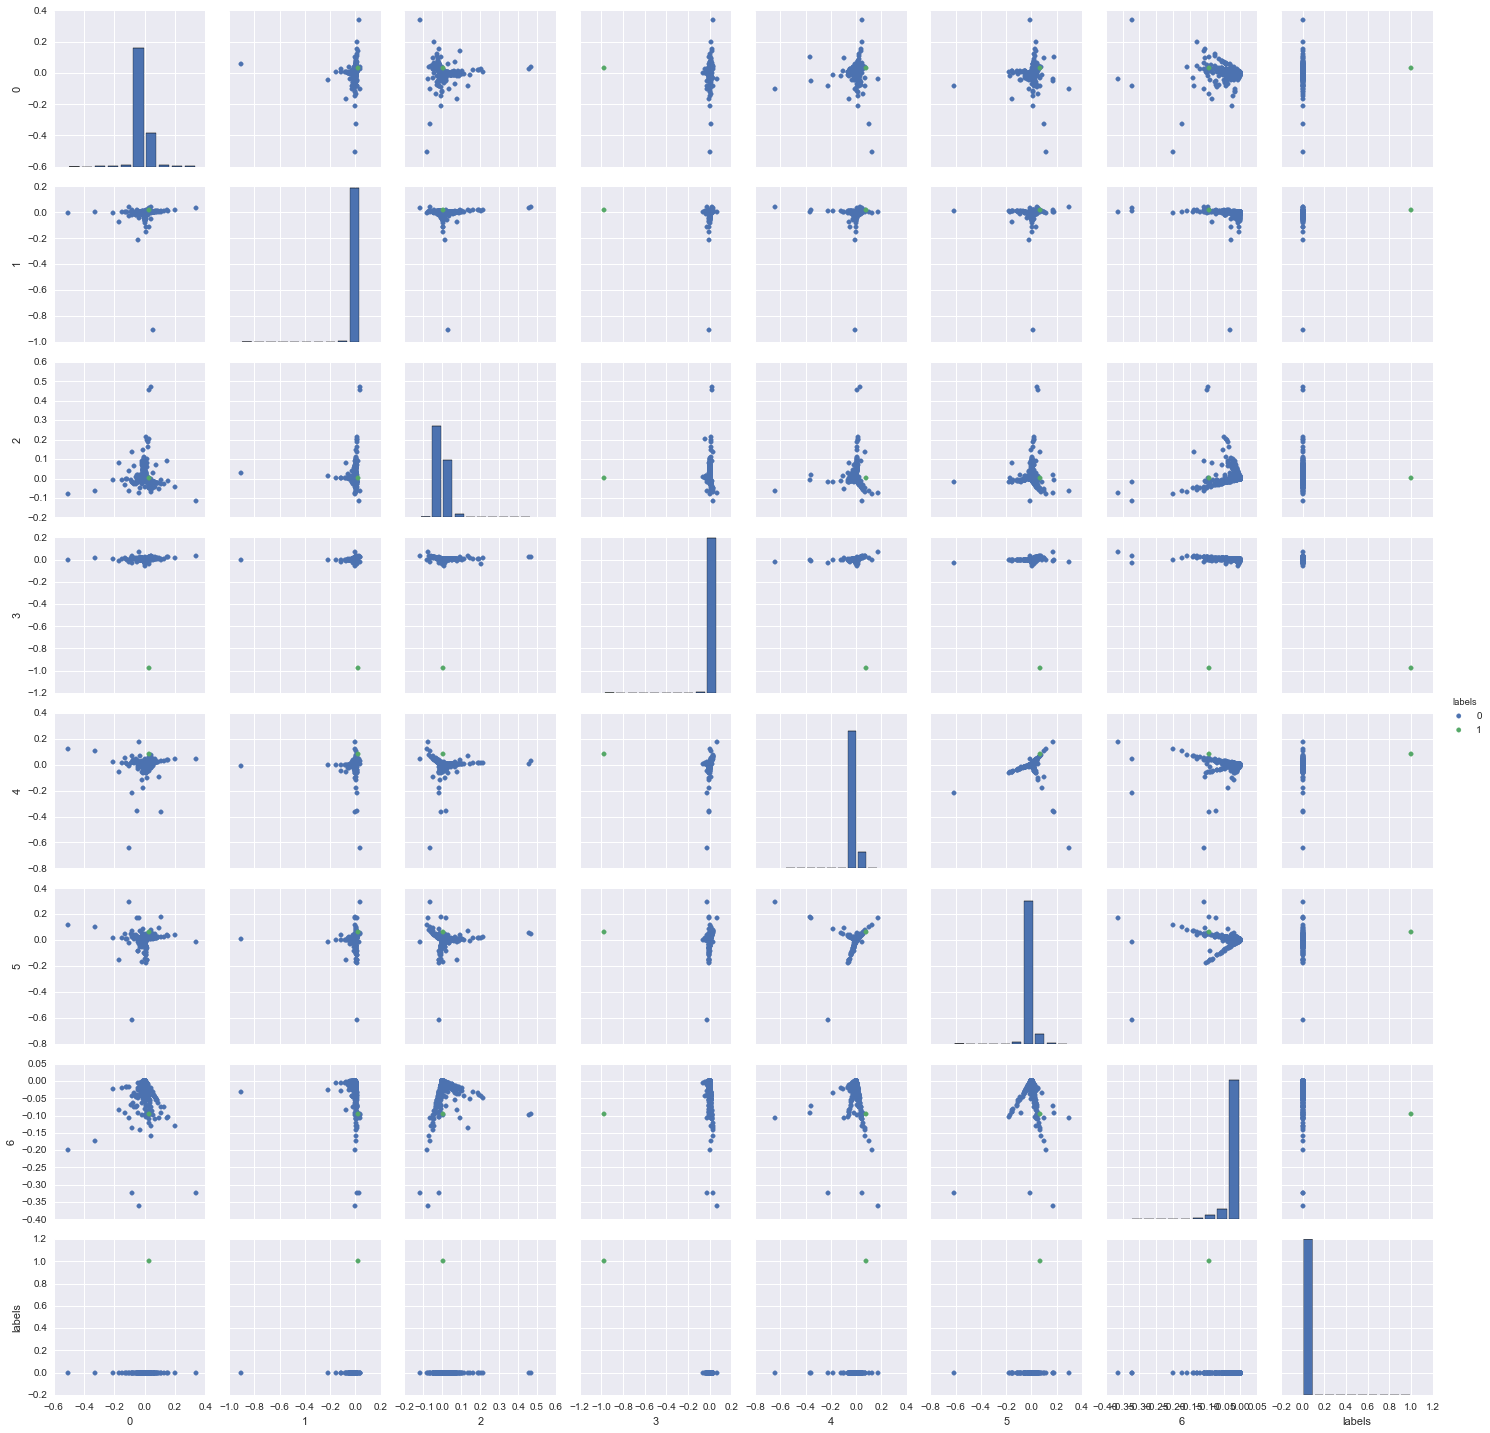

In [133]:
clustering = KMeans(n_clusters=n_clusters)
labels = clustering.fit_predict(u)
df = pd.DataFrame(u)
df['labels'] = labels
sns.pairplot(df, hue='labels')